### Importing Library

This notebook contain several task to create the model and also trained it, there are : simple image preprocessing, extracting dataset, prepare decode and encode algorithm, CTC loss algorithm, CNN - RNN algorithm model. So to achieve that, we prepare some important library
<br>
- OS : to acces dataset in os directory
- cv2 : for image based algorithm
- numpy : for math operation
- pandas : to create dataset
- maplotlib : for plotting process
- pathlib : for convert path to string
- tensorflow & keras : for create model architecture and trained it
- Sklearn : to split dataset

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import  Path

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121

### Acces Dataset

So for the dataset was originally created in a folder contain image contain text image cropped from KTP with arial font (name and addres section). The label was designed to became their text (example: image with '0989' text will be named as '0989.jpg'). Because of that, we used OS to acces it and make it into data set. So here, the running code:

In [2]:

data_dir = Path('C:/Adhi/code/capstone/synthetic_data/generated_images_arial')

image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']  # Add any other image formats you need
images = []
for ext in image_extensions:
    images.extend(sorted(data_dir.glob(ext)))
labels = [img.stem for img in images]
df = pd.DataFrame({'image': images, 'label': labels})

# Display the first few rows of the DataFrame
print(df.head())

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

                                               image          label
0  C:\Adhi\code\capstone\synthetic_data\generated...      A. BASARI
1  C:\Adhi\code\capstone\synthetic_data\generated...       A. RAHIM
2  C:\Adhi\code\capstone\synthetic_data\generated...       A.BASARI
3  C:\Adhi\code\capstone\synthetic_data\generated...     ABD. WAHAB
4  C:\Adhi\code\capstone\synthetic_data\generated...  ABDUL IHSAN 0


In [3]:
train_df.iloc[2]['image']

WindowsPath("C:/Adhi/code/capstone/synthetic_data/generated_images_arial/MUSIM ANGGORO 6 '.png")

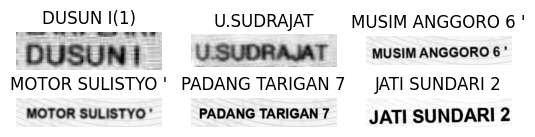

In [4]:
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = train_df.iloc[i]['image']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_df.iloc[i]['label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### Prepare dataset

We acces dataset as directory and access the image using opencv. Later we preproccessing it to became binary image, normalize it into 0-1 and rotate it. The objective to rotate is to make RNN model has large length due to math behaviour of CNN.

In [5]:
train_size = int(0.9*len(df['label']))
valid_size= int(0.1*len(df['label']))

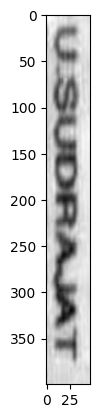

(400, 48)


In [6]:

target_height = 48
target_width = 400

train_x = []

for i in range(len(train_df)):
    img_dir = train_df.iloc[i]['image']  # Use iloc instead of loc
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    image = image / 255.0  # Normalize to 0-1

    # Resize the image to (1000, 120)
    image = cv2.resize(image, (target_width, target_height))  # Resize to (120, 1000)

    # Add resized image to the list
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    train_x.append(image)

# Visualize the first image in the list
plt.imshow(train_x[1], cmap='gray')
plt.show()
print(train_x[0].shape)

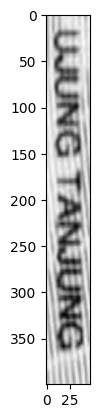

In [7]:
valid_x = []

for i in range(valid_size):
    img_dir = valid_df.iloc[i]['image']  # Use iloc instead of loc
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    image = image / 255.0  # Normalize to 0-1
    # Resize the image to (1000, 120)
    image = cv2.resize(image, (target_width, target_height))  # Resize to (120, 1000)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # Add resized image to the list
    valid_x.append(image)

plt.imshow(valid_x[1], cmap='gray')
plt.show()



In [83]:
train_x = np.array(train_x).reshape(-1, 400, 48, 1)
valid_x = np.array(valid_x).reshape(-1, 400, 48, 1)

### Decoding and Encode

First we define character needed to be detected in KTP in ```alphabets```. Then we define how much character to be decoded (```max_str_len```), and ```num_of_character``` used to prepare ctc algorithm with fill -1 for the blank. And ```Num_of_timestamps``` will be corelated to model so its must align with the output of model. This variable determined maximum character in one prediction. <br>

For encode, we using number in list order align to ```alphabets``` order (expample : 'A' as 0 and 'C' as 2). And decode to reverse it

In [84]:
# Define alphabets with uppercase English letters (A-Z), digits (0-9), and special characters
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789*^_)(- .,'"
max_str_len = 34  # max length of input labels
num_of_characters = len(alphabets) + 1  # +1 for CTC pseudo blank
num_of_timestamps = 100  # max length of predicted labels

# Function to convert label (string) to numerical representation

def label_to_num(label):
    label_num = []
    for ch in label:
        idx = alphabets.find(ch)
        if idx == -1:  # This means the character is not found in the alphabet
            raise ValueError(f"Character '{ch}' not in alphabet.")
        label_num.append(idx)
    return np.array(label_num)


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [85]:
name = train_df.iloc[np.random.randint(1,100)]['label']
print(name, '\n',label_to_num(name),'\n test back','\n',num_to_label(label_to_num(name)))

DAIMIL IKHSAN 
 [ 3  0  8 12  8 11 42  8 10  7 18  0 13] 
 test back 
 DAIMIL IKHSAN


In [86]:
train_size = len(train_df)  # Assuming you have your DataFrame 'train_df'
train_y = np.ones([train_size, max_str_len]) * -1  # Initialize with -1 for CTC blank
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps - 2)  # Adjust for input sequence length
train_output = np.zeros([train_size])

for i in range(train_size):
    label = train_df.iloc[i]['label']
    train_label_len[i] = len(label)  # Store the length of each label
    # Ensure that the label length does not exceed max_str_len
    label_len = min(len(label), max_str_len)
    train_y[i, 0:label_len] = label_to_num(label)[:label_len]  # Fill train_y with encoded label

print(f"train_y shape: {train_y.shape}")
print(f"train_label_len sample: {train_label_len[:5]}")
print(train_y[1])

train_y shape: (1385, 34)
train_label_len sample: [[10.]
 [10.]
 [17.]
 [16.]
 [16.]]
[20. 43. 18. 20.  3. 17.  0.  9.  0. 19. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [87]:
valid_y = np.ones([valid_size, max_str_len]) * -1  # Initialize with -1 for CTC blank
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)  # Adjust for input sequence length
valid_output = np.zeros([valid_size])

# Take the first 'valid_size' samples as validation
for i in range(valid_size):
    label = train_df.iloc[i]['label']
    valid_label_len[i] = len(label)  # Store the length of each label
    # Ensure that the label length does not exceed max_str_len
    label_len = min(len(label), max_str_len)
    valid_y[i, 0:label_len] = label_to_num(label)[:label_len]  # Fill valid_y with encoded label

print(f"valid_y shape: {valid_y.shape}")
print(f"valid_label_len sample: {valid_label_len[:5]}")
print(valid_y[1])  # Print the first validation label

valid_y shape: (173, 34)
valid_label_len sample: [[10.]
 [10.]
 [17.]
 [16.]
 [16.]]
[20. 43. 18. 20.  3. 17.  0.  9.  0. 19. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


### Model Architecture

We defined in fixed ratio and size where heigt are 400 and width 48 for the input, so make sure the image are align with it. In this model contain
- 5 block of CNN 3x3 (each block contain convolution, bach normalization, activation function and max pooling)
- Dropout layer
- Flatten layer
- Hidden layer 
- 2 LSTM layer
- output 

In [ ]:
# Set this according to your dataset
target_height = 400
target_width = 48

input_data = Input(shape=(target_height, target_width, 1), name='input')

# Conv2D Block 1
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

# Conv2D Block 2
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

# Conv2D Block 3
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)

# Conv2D Block 4
inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)

# Conv2D Block 5
inner = Conv2D(128, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max5')(inner)


# CNN to RNN: Flatten and reshape for RNN layers
inner = Reshape(target_shape=(-1, inner.shape[-1]), name='reshape')(inner)  # Automatically determine the sequence length

# Dense layer before RNN layers
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# RNN layers (Bidirectional LSTM)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output layer: Dense layer followed by softmax activation
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Define the model
model = Model(inputs=input_data, outputs=y_pred)

# Model summary
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 400, 48, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 400, 48, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 400, 48, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 400, 48, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 200, 24, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 200, 24, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 200, 24, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 200, 24, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 100, 12, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 100, 12, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 100, 12, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 100, 12, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 100, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 100, 6, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 100, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 100, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max4 (MaxPooling2D)             │ (None, 100, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 100, 3, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 100, 3, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 100, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max5 (MaxPooling2D)             │ (None, 100, 1, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,654,447 (10.13 MB)

 Trainable params: 2,653,487 (10.12 MB)

 Non-trainable params: 960 (3.75 KB)

### CTC-BASED TRAIN

We originally used isolation method with CNN model for each charcter, but its result terible and can not be generally due to image condition. Later, ctc used aligment for each character in order list to make word. One of trademarks in ctc are blank encode of -1. We before state that we decide max lenght of character we predict only to 100 char. That mean, if we want to predict 3 character in that list will be contain 97 of -1.

In [90]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [91]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [93]:

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=40, batch_size=4)

Epoch 1/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 159s 432ms/step - loss: 46.7770 - val_loss: 41.0989
Epoch 2/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 182s 525ms/step - loss: 39.3662 - val_loss: 25.5506
Epoch 3/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 168s 484ms/step - loss: 22.2305 - val_loss: 13.3048
Epoch 4/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 149s 431ms/step - loss: 12.1358 - val_loss: 7.9599
Epoch 5/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 160s 460ms/step - loss: 8.3976 - val_loss: 5.9533
Epoch 6/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 150s 431ms/step - loss: 6.7976 - val_loss: 4.4920
Epoch 7/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 150s 431ms/step - loss: 5.4898 - val_loss: 3.8810
Epoch 8/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 174s 500ms/step - loss: 4.3157 - val_loss: 3.3132
Epoch 9/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 158s 455ms/step - loss: 3.8693 - val_loss: 3.3247
Epoch 10/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 162s 467ms/step - loss: 3.5707 - val_loss: 2.5351
Epoch 11/40
347/347 ━━━━━━━━━━━━━━━━━━━━ 149s 429ms/step - loss: 2.9873 - val_loss: 2.5046
E

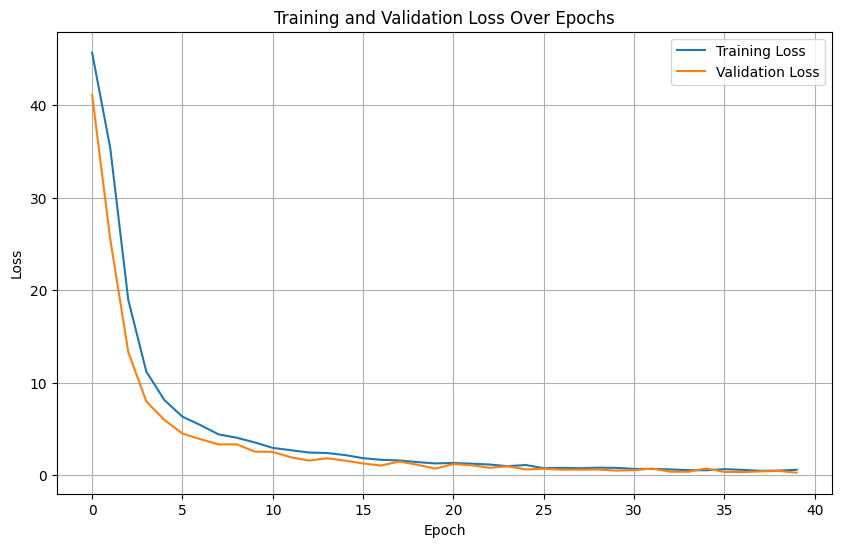

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
model.save('C:/Adhi/code/capstone/ar_ver2.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step


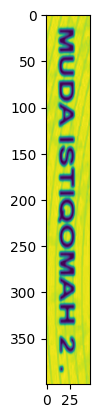

MUDA ISTIQOMAH 2 .


In [96]:
preds = model.predict(valid_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode (preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
plt.imshow(valid_x[6])
plt.show()
print(prediction[6])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


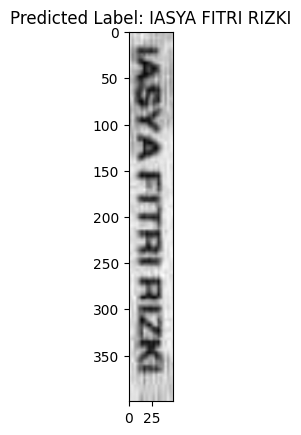

Predicted label: IASYA FITRI RIZKI


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to load, resize, rotate and preprocess the image
def preprocess_image(image_path, target_height=48, target_width=400):
    # Load the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale (single channel)
    
    # Resize the image to the target dimensions (400x48)
    img_resized = cv2.resize(img, (target_width, target_height))
    
    # Normalize the image to [0, 1] range
    img_resized = img_resized / 255.0
    
    # Rotate the image 90 degrees clockwise
    img_resized = cv2.rotate(img_resized, cv2.ROTATE_90_CLOCKWISE)
    
    img_resized = np.expand_dims(img_resized, axis=-1) 
    img_resized = np.expand_dims(img_resized, axis=0)  
    
    return img_resized

# Load and preprocess the image
image_path = 'C:/Adhi/code/capstone/cropped_datasetKTP/train/images/1271076401000001_crop_1.jpg' #used your path
image = preprocess_image(image_path)

# Make the prediction
preds = model.predict(image)

# CTC Decode
input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Use the length of the output sequence
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=input_length, greedy=True)[0][0])

# Convert the predicted labels back to text
prediction = num_to_label(decoded[0])

# Plot the image and display the predicted label
plt.imshow(image[0, :, :, 0], cmap='gray')
plt.title(f'Predicted Label: {prediction}')
plt.show()

# Print the prediction
print("Predicted label:", prediction)
